YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


First few rows of the merged DataFrame:
                  DBO        WTI        DXY
2010-01-01  24.655401  81.510002  77.529999
2010-01-02  24.655401  81.510002  77.529999
2010-01-03  24.655401  81.510002  77.529999
2010-01-04  24.655401  81.510002  77.529999
2010-01-05  24.883610  81.769997  77.620003


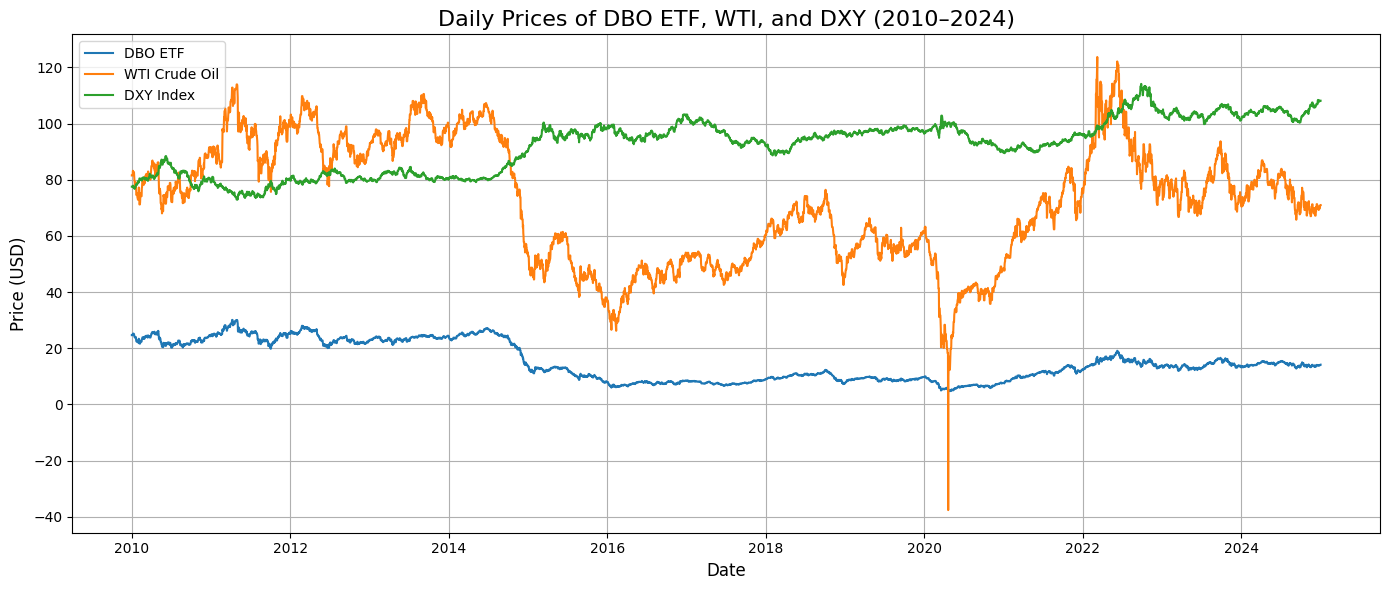

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define ticker symbols and corresponding Yahoo Finance symbols:
tickers = {
    "DBO": "DBO",          # Invesco DB Oil Fund ETF
    "WTI": "CL=F",         # WTI Crude Oil Futures
    "DXY": "DX-Y.NYB"      # U.S. Dollar Index
}

# Set the date range for data collection
start_date = "2010-01-01"
end_date = "2024-12-31"

# Download daily close price data for each ticker
price_data = {}
for label, symbol in tickers.items():
    df = yf.download(symbol, start=start_date, end=end_date)
    # Extract the "Close" column for each asset
    price_data[label] = df["Close"]

# Merge the individual Series into a single DataFrame.
# This produces a MultiIndex; we drop the inner level.
data = pd.concat(price_data, axis=1)
data.columns = data.columns.droplevel(1)  # Now columns are 'DBO', 'WTI', 'DXY'

# Create a complete daily date range (including non-trading days)
all_days = pd.date_range(start=start_date, end=end_date, freq='D')
data = data.reindex(all_days)

# Ensure the index is a DateTimeIndex with daily frequency
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')

# Replace any Inf or -Inf with NaN
data = data.replace([np.inf, -np.inf], np.nan)

# Handle missing values: first forward fill, then backward fill, then interpolate any remaining gaps
data = data.ffill().bfill().interpolate()

# Show the first few rows of the merged DataFrame
print("First few rows of the merged DataFrame:")
print(data.head())

# Visualization using the provided code snippet:
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['DBO'], label='DBO ETF')
plt.plot(data.index, data['WTI'], label='WTI Crude Oil')
plt.plot(data.index, data['DXY'], label='DXY Index')

plt.title('Daily Prices of DBO ETF, WTI, and DXY (2010–2024)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Missing values in training set (before modeling):
DBO    0
WTI    0
DXY    0
dtype: int64

Missing values in test set (before forecasting):
WTI    0
DXY    0
dtype: int64

ADF Statistic: -0.9981
p-value: 0.7539
Differencing order applied: 1

ARIMAX Model Summary:
                               SARIMAX Results                                
Dep. Variable:                    DBO   No. Observations:                 3652
Model:               SARIMAX(1, 1, 1)   Log Likelihood                3281.588
Date:                Sat, 19 Apr 2025   AIC                          -6553.177
Time:                        00:03:18   BIC                          -6522.166
Sample:                    01-01-2010   HQIC                         -6542.133
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

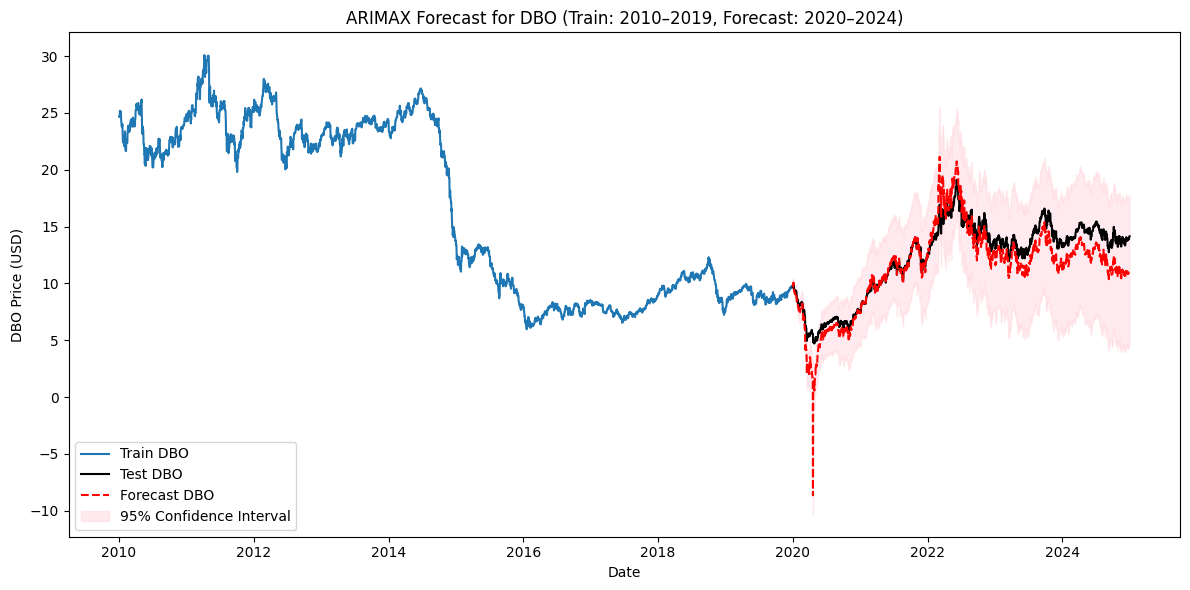

In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Ensure the data index is a DateTimeIndex with daily frequency ---
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')

# --- Split data into training (2010–2019) and testing (2020–2024) sets ---
train = data.loc['2010-01-01':'2019-12-31']
test = data.loc['2020-01-01':'2024-12-31']

# --- Optional: Final check to confirm no NaNs in the critical columns ---
print("Missing values in training set (before modeling):")
print(train[['DBO', 'WTI', 'DXY']].isna().sum())
print("\nMissing values in test set (before forecasting):")
print(test[['WTI', 'DXY']].isna().sum())

# --- Stationarity Test on DBO (target) using Augmented Dickey-Fuller (ADF) ---
adf_result = adfuller(train['DBO'].dropna())
print('\nADF Statistic: {:.4f}'.format(adf_result[0]))
print('p-value: {:.4f}'.format(adf_result[1]))

# Set differencing order based on the ADF test p-value (d=1 if non-stationary, else d=0)
d_order = 1 if adf_result[1] > 0.05 else 0
print("Differencing order applied:", d_order)

# --- Build the ARIMAX Model using SARIMAX ---
# Using a simple ARIMA order of (1, d_order, 1)
model = SARIMAX(train['DBO'],
                exog=train[['WTI', 'DXY']],
                order=(1, d_order, 1),
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=False)
print("\nARIMAX Model Summary:")
print(model_fit.summary())

# --- Forecasting for the period 2020–2024 ---
forecast_steps = len(test)
print("\nForecast steps:", forecast_steps)

# Ensure that the exogenous test DataFrame matches the forecast period's length
print("Test exogenous variables shape:", test[['WTI', 'DXY']].shape)

forecast_res = model_fit.get_forecast(steps=forecast_steps, exog=test[['WTI', 'DXY']])
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

# --- Visualization of the forecast ---
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['DBO'], label='Train DBO')
plt.plot(test.index, test['DBO'], label='Test DBO', color='black')
plt.plot(test.index, forecast_mean, label='Forecast DBO', color='red', linestyle='--')
plt.fill_between(test.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('ARIMAX Forecast for DBO (Train: 2010–2019, Forecast: 2020–2024)')
plt.xlabel('Date')
plt.ylabel('DBO Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()
